In [15]:
import pandas as pd

# Load the dataset and remove the first row (blank row)
file_path = '/Users/takaya/Desktop/app_wonder_palette/new_product/grs/AI需要予測送付用(15).xlsx'

data = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=1, header=None)

# Extract the first column as the date/label column
date_and_labels = data.iloc[:, 0]  # First column

# Create 商品ID and 商品ID_名前 excluding the first column
商品ID = data.iloc[0, 1:].astype(str) + '_' + data.iloc[2, 1:].astype(str) + '_' + \
         data.iloc[4, 1:].astype(str) + '_' + data.iloc[6, 1:].astype(str)
商品ID_名前 = data.iloc[1, 1:].astype(str) + '_' + data.iloc[3, 1:].astype(str) + '_' + \
             data.iloc[5, 1:].astype(str) + '_' + data.iloc[7, 1:].astype(str)

# Replace "nan" with empty strings
商品ID_名前 = 商品ID_名前.str.replace('nan', '', regex=False)

# Extract sales data starting from the 10th row (1-indexed), excluding the first column
sales_data_start_row = 9  # Row 10 in Excel
sales_data = data.iloc[sales_data_start_row:, 1:].reset_index(drop=True)

# Extract actual sales dates from the first column
sales_dates = pd.to_datetime(date_and_labels.iloc[sales_data_start_row:], errors='coerce')
sales_dates = sales_dates.reset_index(drop=True)

# Assign 商品ID_名前 as the headers for the sales data
sales_data.columns = 商品ID_名前

# Add the extracted sales dates as the Date column
sales_data.insert(0, 'Date', sales_dates)

# Convert the dataset into long format
long_format = sales_data.melt(
    id_vars=['Date'],  # Keep the Date column as identifier
    var_name='商品ID_名前',  # Use 商品ID_名前 as the column name for variable
    value_name='Sales'  # The sales values
)

long_format['Sales'] = long_format['Sales'].fillna(0)

In [16]:
# Define training and test date ranges
train_start_date = pd.Timestamp('2022-01-20')
train_end_date = pd.Timestamp('2024-11-24')
test_start_date = pd.Timestamp('2024-11-25')
test_end_date = pd.Timestamp('2025-01-19')

# Split the data into training and test sets
train_data = long_format[(long_format['Date'] >= train_start_date) & (long_format['Date'] <= train_end_date)]
test_data = long_format[(long_format['Date'] >= test_start_date) & (long_format['Date'] <= test_end_date)]

In [23]:
import pandas as pd

# Compute the duration of sales for each product
sales_duration = (
    train_data[train_data["Sales"] > 0]
    .groupby("商品ID_名前")["Date"]
    .agg(["min", "max"])
    .reset_index()
)

# Calculate the number of days between first sale and train_end_date
sales_duration["days_sold"] = (train_end_date - sales_duration["min"]).dt.days

# Define the cutoff date for the last 1 year
one_year_ago = train_end_date - pd.DateOffset(days=365)

# Check if the product has at least one sale in the last 1 year
sales_last_year = (
    train_data[(train_data["Sales"] > 0) & (train_data["Date"] >= one_year_ago)]
    .groupby("商品ID_名前")["Date"]
    .count()
    .reset_index()
    .rename(columns={"Date": "sales_last_year_count"})
)

# Merge with sales_duration to ensure both conditions are met
sales_duration = sales_duration.merge(sales_last_year, on="商品ID_名前", how="left").fillna(0)

# Identify new products: Sold for less than 1 year AND has at least 1 sale in the last year
new_products = sales_duration[
    (sales_duration["days_sold"] < 365) & (sales_duration["sales_last_year_count"] > 0)
]["商品ID_名前"].tolist()

# Display the number of new products
print(f"Number of new products: {len(new_products)}")

print(new_products)
#new_products = new_products[:50]  # Limit the number of new products for demonstration

Number of new products: 412
['【卸】EC_KAMAKURA茶の福_お抹茶ショコラサンド_お抹茶ショコラサンド', '【卸】EC_KAMAKURA茶の福_茶の福その他単品_お抹茶ラテタルト', '【卸】EC_KAMAKURA茶の福_茶の福その他単品_黒ゴマ抹茶サンド', '【卸】EC_KAMAKURA茶の福_茶の福各種詰合せ_茶の福詰合せ', '【卸】EC_TOKYOチューリップローズ_TRその他単品_チューリップローズサンド', '【卸】EC_TOKYOチューリップローズ_TR各種詰合せ_チューリップローズ詰合せ', '【卸】EC_TOKYOチューリップローズ_TR季節イベント_チューリップローズサンド', '【卸】EC_TOKYOチューリップローズ_チューリップローズラング_チューリップローズラングショコラティエ', '【卸】EC_ねんりん家_ねんりん季節イベント_MTホワイトステージ', '【卸】EC_ねんりん家_ねんりん季節イベント_ねんりん家イベント詰合せ', '【卸】EC_ねんりん家_マウントバーム_MTレモン', '【卸】EC_ねんりん家_マウントバーム_MT抹茶', '【卸】EC_シュガーバターの木_SBTショコラがけサンド_SBTサンド苺ショコラ', '【卸】EC_シュガーバターの木_ネスレキットカット_SBTキットカット', '【卸】EC_ナッツストック実森_お抹茶ショコラサンド_お抹茶ショコラサンド', '【卸】EC_ブリュレメリゼ_ブリュレクリームタルト_ブリュレクリームタルト季節味', '【卸】EC_東京ばな奈ワールド_ばな奈Wその他単品_東京ばな奈カステラ', '【卸】EC_東京ばな奈ワールド_ばな奈Wその他単品_東京ばな奈ラスク', '【卸】EC_東京ばな奈ワールド_ディズニースイーツbyばな奈_WDJクッキー(WISH)', '【卸】EC_東京ばな奈ワールド_ディズニースイーツbyばな奈_WDJショコラサンド(チップ＆デール)', '【卸】EC_東京ばな奈ワールド_ディズニースイーツbyばな奈_WDJショコラサンド(ラプンツェル)', '【卸】EC_東京ばな奈ワールド_レトルト食品_レトルトカレー', '【卸】EC_東京ばな奈ワールド_東京ばな奈_東京ばな奈', '【卸】EC_東京ばな奈ワールド_銀座のケー

In [24]:
import pandas as pd

file_path = '/Users/takaya/Desktop/app_wonder_palette/new_product/grs/需要予測_アイテムフラグ分け_グレープストーン様.xlsx'
data_label = pd.read_excel(file_path, skiprows=1, header=None)

def extract_label_data(data_label, new_products):
    processed_products = []

    for new_product in new_products:
        # Extract the relevant part of 商品ID_名前 (last three sections)
        product_name_parts = new_product["商品ID_名前"].split("_")
        if len(product_name_parts) >= 3:
            identification_part = "_".join(product_name_parts[-3:])  # Get the last 3 parts
        else:
            identification_part = new_product["商品ID_名前"]  # Use the full name if less than 3 parts

        # Check if it exists in data_label column 7
        match_rows = data_label[data_label[7].astype(str) == identification_part]

        if not match_rows.empty:
            new_product["Label"] = match_rows.iloc[0, 9]  # Column 9 contains the label

            if new_product["Label"] == "季節商品":
                new_product["Season_label"] = (match_rows.iloc[0, 10], match_rows.iloc[0, 11])  # Start and End date
                new_product["Season_label_2"] = (match_rows.iloc[0, 12], match_rows.iloc[0, 13]) if not pd.isna(match_rows.iloc[0, 12]) else None
            else:
                new_product["Season_label"] = None
                new_product["Season_label_2"] = None
        else:
            new_product["Label"] = "未分類"  # Assign a default label if not found
            new_product["Season_label"] = None
            new_product["Season_label_2"] = None

        processed_products.append(new_product)

    # Convert list of dictionaries to DataFrame
    df_result = pd.DataFrame(processed_products)

    # Count occurrences of each label
    label_counts = df_result["Label"].value_counts().reset_index()
    label_counts.columns = ["Label", "Count"]

    # Save the processed data and label counts to an Excel file
    output_path = "/Users/takaya/Desktop/app_wonder_palette/new_product/processed_products.xlsx"
    with pd.ExcelWriter(output_path) as writer:
        df_result.to_excel(writer, sheet_name="Processed Data", index=False)
        label_counts.to_excel(writer, sheet_name="Label Counts", index=False)

    print(f"Processed data saved to {output_path}")

    return df_result

# Example usage
new_products = [
    {"商品ID_名前": "【卸】EC_KAMAKURA茶の福_お抹茶ショコラサンド_お抹茶ショコラサンド"},
    {"商品ID_名前": "【直販】ABC_チョコレート_マカロン"},
]

result_df = extract_label_data(data_label, new_products)


Processed data saved to /Users/takaya/Desktop/app_wonder_palette/new_product/processed_products.xlsx


In [6]:
from collections import defaultdict
import pandas as pd

# Initialize a dictionary to count failures for each criterion
failure_counts = defaultdict(int)

# Define the training start date
train_start_date = pd.Timestamp('2022-01-20')

# Function to validate a product group
def validate_product(group):
    global failure_counts  # Use global to update counts outside the function
    
    # Filter for non-zero sales data
    non_zero_sales = group[group['Sales'] > 0]
    
    # Criterion 1: Valid duration (Start and end of non-zero sales)
    if non_zero_sales.empty:
        failure_counts['No Non-Zero Sales'] += 1
        return False
    
    duration = (non_zero_sales['Date'].max() - non_zero_sales['Date'].min()).days
    if duration < (365 + 30):  # 1 year and 1 month
        failure_counts['Invalid Duration'] += 1
        return False
    
    # Criterion 2: Non-zero rate from start of non-zero data
    non_zero_start_date = non_zero_sales['Date'].min()
    relevant_data = group[group['Date'] >= non_zero_start_date]  # Data after the first non-zero sale
    non_zero_rate = (relevant_data['Sales'] > 0).mean()
    
    if non_zero_rate <= 0.80:
        failure_counts['Low Non-Zero Rate'] += 1
        return False

    # Criterion 3: Sales at start of training (First three-days sales must be all zero)
    first_week_sales = group[(group['Date'] >= train_start_date) & 
                             (group['Date'] < train_start_date + pd.Timedelta(days=1))]
    if not (first_week_sales['Sales'] == 0).all():
        failure_counts['Non-Zero Sales in First Week'] += 1
        return False
    
    return True

# Function to find all seed product candidates
def get_all_seed_candidates(data):
    seed_candidates = []
    grouped = data.groupby('商品ID_名前')
    
    for product, group in grouped:
        # Validate the product
        if validate_product(group):
            seed_candidates.append(product)
    
    return seed_candidates

# Function to find seed products for a specific target product
def find_seed_product(target_product, seed_candidates):
    # Pre-check: Ensure the target product exists in the training dataset
    if target_product not in train_data['商品ID_名前'].values:
        print(f"Target product '{target_product}' does not exist in the training dataset.")
        return []
    
    # Split 商品ID_名前 into elements for comparison
    target_elements = target_product.split('_')
    
    # Define levels of similarity
    similarity_levels = [
        lambda x: x == target_product,  # Exact match
        lambda x: '_'.join(x.split('_')[:3]) == '_'.join(target_elements[:3]),  # First 3 elements match
        lambda x: '_'.join(x.split('_')[:2]) == '_'.join(target_elements[:2]),  # First 2 elements match
        lambda x: x.split('_')[0] == target_elements[0],  # First element matches
    ]
    
    # Iterate through similarity levels
    for level in similarity_levels:
        similar_products = [prod for prod in seed_candidates if level(prod)]
        if len(similar_products) >= 2:
            print(f"Seed products found for '{target_product}': {similar_products}")
            return similar_products
    
    # If no matches found
    print(f"No seed products found for '{target_product}'.")
    return []

# Step 1: Find all seed product candidates
seed_candidates = get_all_seed_candidates(train_data)
print("number of seed candidates:", len(seed_candidates))

# Display failure counts for each criterion
print("\nFailure Counts for Each Criterion:")
for criterion, count in failure_counts.items():
    print(f"{criterion}: {count}")


number of seed candidates: 132

Failure Counts for Each Criterion:
Invalid Duration: 1262
No Non-Zero Sales: 67
Low Non-Zero Rate: 909
Non-Zero Sales in First Week: 163


In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning


def calculate_sales_ratios_with_weighted_scaling(group):
    """
    Calculate sales ratios for a seed product, including:
    - Scaling for additional durations.
    - Taking the weighted average for the same day-month across multiple years.

    Args:
    - group: A DataFrame group representing sales data for a single product.

    Returns:
    - A DataFrame with calculated ratios.
    """
    # Filter non-zero sales data
    non_zero_sales = group[group['Sales'] > 0]
    if non_zero_sales.empty:
        return pd.DataFrame()  # No data to process

    # Start and end of non-zero sales
    start_date = non_zero_sales['Date'].min()
    #print("start_date:", start_date)
    end_date = non_zero_sales['Date'].max()
    #print("end_date:", end_date)

    # Initialize the result DataFrame
    result = pd.DataFrame(columns=['Date', 'Ratio', 'Adjusted_Ratio'])

    # Process full years and additional durations
    current_start = start_date
    # Define the current year's duration
    next_year_start = current_start + pd.Timedelta(days=365)
    current_year_data = group[(group['Date'] >= current_start) & (group['Date'] < next_year_start)]

    # Compute the daily sales ratio for the current year
    if not current_year_data.empty:
        total_sales = current_year_data['Sales'].sum()
        current_year_data['Ratio'] = current_year_data['Sales'] / total_sales
        result = pd.concat([result, current_year_data[['Date', 'Ratio']]])
        #print("ratio for first year", result["Ratio"].sum())
    while next_year_start <= end_date:
        # Handle additional durations (extra years or months)
        if next_year_start <= end_date:
            extra_duration_end = min(next_year_start + pd.Timedelta(days=365), end_date)
            extra_duration_data = group[(group['Date'] >= next_year_start) & (group['Date'] <= extra_duration_end)]
            #print("extra_duration_data:", extra_duration_data)

            if not extra_duration_data.empty:
                # Calculate initial ratios for the additional duration
                extra_total_sales = extra_duration_data['Sales'].sum()
                extra_duration_data['Ratio'] = extra_duration_data['Sales'] / extra_total_sales

                # Determine equivalent period in the previous year for scaling
                #prev_start = next_year_start - pd.Timedelta(days=(extra_duration_end - next_year_start).days)
                prev_start = next_year_start - pd.Timedelta(days=365)
                #print("prev_start:", prev_start)
                prev_end = min(next_year_start, end_date - pd.Timedelta(days=365))
                #print("prev_end:", prev_end)
                previous_year_data = group[(group['Date'] >= prev_start) & (group['Date'] <= prev_end)]

                if not previous_year_data.empty:
                    previous_year_total = previous_year_data['Sales'].sum()
                    scaling_factor = previous_year_total / total_sales if total_sales > 0 else 1
                    #print("scaling_factor:", scaling_factor)
                    extra_duration_data['Adjusted_Ratio'] = extra_duration_data['Ratio'] * scaling_factor
                else:
                    extra_duration_data['Adjusted_Ratio'] = extra_duration_data['Ratio']  # No scaling available

                # Add the scaled ratios to the result
                result = pd.concat([result, extra_duration_data[['Date', 'Ratio', 'Adjusted_Ratio']]])
                #print("ratio_sum_inside_for_loop", result["Ratio"].sum())
                
        next_year_start = next_year_start + pd.Timedelta(days=365)

    # Compute averages for the same day-month across all years with weighted averaging
    result['Day-Month'] = result['Date'].dt.strftime('%m-%d')
    #print("ratio_sum_after_loop", result["Ratio"].sum())

    # Compute Weighted Average Ratio: Prioritizing Adjusted_Ratio if available
    result['Weighted_Average_Ratio'] = result.apply(
        lambda row: row['Adjusted_Ratio'] if not pd.isnull(row['Adjusted_Ratio']) else row['Ratio'],
        axis=1
    )
    #print("weighted_ratio_sum", result["Weighted_Average_Ratio"].sum())
    #print("ratio_sum", result["Ratio"].sum())
    #print("Adjusted ratio sum:", result["Adjusted_Ratio"].sum())

    result['Weighted_Average_Ratio'] = result.groupby('Day-Month')['Weighted_Average_Ratio'].transform('mean')


    return result



In [8]:
import pandas as pd

def process_seed_product_ratios_with_sales(final_results, train_data, seed_products):
    """
    Rescale ratios, retrieve actual sales, and calculate the change rate for each day,
    averaging across all seed products. Applies a 7-day moving average to sales and ratios first,
    then calculates the change rate.

    Args:
    - final_results: DataFrame containing pre-calculated weighted ratios for all seed products.
    - train_data: DataFrame containing actual sales data.
    - seed_products: List of seed products.

    Returns:
    - DataFrame with the average change rate for each day since the first non-zero sales.
    """
    all_results = []

    for seed_product in seed_products:
        # Filter data for the seed product in final_results
        seed_product_ratios = final_results[final_results['Seed_Product'] == seed_product].copy()

        # Ensure the Date column is in datetime format
        seed_product_ratios['Date'] = pd.to_datetime(seed_product_ratios['Date'], errors='coerce')

        # Retrieve the actual sales data from train_data for the seed product
        seed_product_sales = train_data[train_data['商品ID_名前'] == seed_product].copy()
        seed_product_sales['Date'] = pd.to_datetime(seed_product_sales['Date'], errors='coerce')

        # Merge actual sales data with the ratios data on Date
        seed_product_data = pd.merge(
            seed_product_ratios, seed_product_sales[['Date', 'Sales']],
            on='Date', how='inner'
        )

        # Define the first and last non-zero sales dates
        first_non_zero_date = seed_product_data[seed_product_data['Weighted_Average_Ratio'] > 0]['Date'].min()

        # Apply 7-day moving average **before** calculating change rate
        seed_product_data['Sales_MA7'] = seed_product_data['Sales'].rolling(window=7, min_periods=1).mean()
        seed_product_data['Ratio_MA7'] = seed_product_data['Weighted_Average_Ratio'].rolling(window=7, min_periods=1).mean()

        # Rescale the weighted ratios so that the sum becomes 1
        total_ratio_sum = seed_product_data['Ratio_MA7'].sum()
        seed_product_data['Rescaled_Ratio'] = seed_product_data['Ratio_MA7'] / total_ratio_sum

        # Rescale the actual sales data for the entire duration
        total_actual_sales = seed_product_data['Sales_MA7'].sum()
        seed_product_data['Rescaled_Actual_Sales'] = seed_product_data['Sales_MA7'] / total_actual_sales

        # Calculate the change rate **after applying the 7-day moving average**
        seed_product_data['Change_Rate'] = seed_product_data.apply(
            lambda row: row['Rescaled_Actual_Sales'] / row['Rescaled_Ratio']
            if row['Rescaled_Ratio'] > 0 else 0, axis=1
        )

        # Add a "Days Passed" column since the first non-zero sale
        seed_product_data['Days_Passed'] = (seed_product_data['Date'] - first_non_zero_date).dt.days

        # Append the processed data
        all_results.append(seed_product_data[['Days_Passed', 'Change_Rate']])

    # Combine results from all seed products
    combined_results = pd.concat(all_results, ignore_index=True)

    # Compute the overall average change rate across all products
    average_change_rate = combined_results.groupby('Days_Passed', as_index=False)['Change_Rate'].mean()

    return average_change_rate


In [9]:
import pandas as pd

def predict_new_product_sales_without_smoothing(
    train_data, final_results, seed_365_avg, change_rate, new_product_name, test_start, test_end
):
    """
    Predict sales for the test data period for a new product using the original change rates
    and averaged seed product 365-day composition ratios.

    Args:
    - train_data: DataFrame containing actual sales data for seed and new products.
    - final_results: DataFrame containing pre-calculated ratios for seed products.
    - seed_365_avg: DataFrame containing the averaged 365-day composition ratio for seed products.
    - change_rate: DataFrame containing the raw change rate (without smoothing).
    - new_product_name: Name of the new product to predict sales for.
    - test_start: Start date of the test period (YYYY-MM-DD).
    - test_end: End date of the test period (YYYY-MM-DD).

    Returns:
    - DataFrame with predicted sales for the new product during the test period.
    """

    # Ensure dates are in datetime format
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    train_data['Date'] = pd.to_datetime(train_data['Date'], errors='coerce')

    # Retrieve new product sales data
    new_product_data = train_data[train_data['商品ID_名前'] == new_product_name].copy()

    # Ensure non-zero sales for the new product
    non_zero_new_sales = new_product_data[new_product_data['Sales'] > 0]
    if non_zero_new_sales.empty:
        raise ValueError("No non-zero sales data available for the new product.")

    # Find the actual first non-zero date in the entire training dataset
    new_start_date = new_product_data.loc[new_product_data['Sales'] > 0, 'Date'].min()

    new_product_data = new_product_data[new_product_data['Date'] >= new_start_date]
    new_product_data['Days_Passed'] = (new_product_data['Date'] - new_start_date).dt.days

    # Merge new product data with the raw change rate (instead of smoothed)
    merged_data = pd.merge(new_product_data, change_rate, on='Days_Passed', how='left')

    # Rescale new product sales using the raw change rate
    merged_data['Adjusted_Sales'] = merged_data['Sales'] / merged_data['Change_Rate']

    # Compute scaling factor to match the seed product 365-day composition ratio
    seed_365_avg_copy = seed_365_avg.copy()

    # Extract the relevant duration from seed_365_avg_copy to match new product data duration
    start_day_month = new_start_date.strftime('%m-%d')
    end_day_month = merged_data['Date'].max().strftime('%m-%d')

    # Filter only the corresponding period in the seed product composition ratio,
    # accounting for cases where the period spans across two calendar years.
    if start_day_month <= end_day_month:
        # Case 1: The period is within a single year (e.g., 03-01 to 08-15)
        seed_365_avg_filtered = seed_365_avg_copy[
            (seed_365_avg_copy['Day-Month'] >= start_day_month) &
            (seed_365_avg_copy['Day-Month'] <= end_day_month)
        ]
    else:
        # Case 2: The period spans across two years (e.g., 10-01 to 02-01)
        seed_365_avg_filtered = seed_365_avg_copy[
            (seed_365_avg_copy['Day-Month'] >= start_day_month) |
            (seed_365_avg_copy['Day-Month'] <= end_day_month)
        ]

    print("start_day_month:", start_day_month)
    print("end_day_month:", end_day_month)

    # Compute scaling factor safely
    seed_ratio_sum = seed_365_avg_filtered['シード商品365日構成比'].sum()
    adjusted_sales_sum = merged_data['Adjusted_Sales'].sum()

    if seed_ratio_sum == 0:
        print(f"Warning: Zero denominator encountered for {new_product_name}. Setting scaling factor to 1.0")
        scaling_factor = 1.0  # Default to 1 if division is not possible
    else:
        scaling_factor = adjusted_sales_sum / seed_ratio_sum

    print(f"Scaling Factor for {new_product_name}: {scaling_factor:.4f}")
    
    scaling_factor = merged_data['Adjusted_Sales'].sum() / seed_365_avg_filtered['シード商品365日構成比'].sum()
    print("seed_365_avg_filtered['シード商品365日構成比'].sum():", seed_365_avg_filtered['シード商品365日構成比'].sum())
    seed_365_avg_copy['Rescaled_Seed_Composition'] = seed_365_avg_copy['シード商品365日構成比'] * scaling_factor

    # Predict sales for the test period using the rescaled composition ratio
    test_days = (test_end - test_start).days + 1
    test_dates = [test_start + pd.Timedelta(days=i) for i in range(test_days)]
    test_predictions = pd.DataFrame({'Date': test_dates})
    test_predictions['Day-Month'] = test_predictions['Date'].dt.strftime('%m-%d')

    # Merge with rescaled seed composition ratio
    test_predictions = pd.merge(test_predictions, seed_365_avg_copy, on='Day-Month', how='left')

    # Fill missing values with nearest available data
    test_predictions['Rescaled_Seed_Composition'].fillna(method='ffill', inplace=True)

    # Merge with raw change rate for dynamic adjustment
    test_predictions['Days_Passed'] = (test_predictions['Date'] - new_start_date).dt.days
    test_predictions = pd.merge(test_predictions, change_rate, on='Days_Passed', how='left')

    # Compute final predicted sales using `Change_Rate` instead of `Smoothed_Change_Rate`
    test_predictions['Predicted_Sales'] = (
        test_predictions['Rescaled_Seed_Composition'] * test_predictions['Change_Rate']
    )

    # Filter predictions within the test period
    test_predictions = test_predictions[(test_predictions['Date'] >= test_start) & (test_predictions['Date'] <= test_end)]

    return test_predictions[['Date', 'Predicted_Sales']]
 

In [10]:
file_path_old = "item手法B込1年分.xlsx"

### --- Compute MAE --- ###
def compute_mae(predictions, actual_sales, column_name):
    """ Compute Mean Absolute Error (MAE) between actual sales and predicted sales. """
    comparison = pd.merge(predictions, actual_sales, on='Date', how='inner')
    mae = np.mean(np.abs(comparison['Actual_Sales'] - comparison[column_name]))
    return mae

### --- Load Another Algorithm’s Predictions --- ###
def load_old_algorithm_predictions(file_path_old, new_product_name):
    """ Extract the prediction series for the given new product from another algorithm’s Excel file. """
    another_prediction = pd.read_excel(file_path_old, skiprows=0, header=None)

    # Extract product IDs from metadata
    product_ids = another_prediction.iloc[1, 1:].astype(str) + '_' + another_prediction.iloc[3, 1:].astype(str) + '_' + \
                  another_prediction.iloc[5, 1:].astype(str) + '_' + another_prediction.iloc[7, 1:].astype(str)

    # Locate column index for the new product
    if new_product_name in product_ids.values:
        column_index = product_ids[product_ids == new_product_name].index[0] + 1  # Adjust for 0-based indexing
        another_predictions_series = another_prediction.iloc[9:, column_index]  # Extract sales from row 10 onwards
        another_predictions_series = another_predictions_series.reset_index(drop=True)

        return another_predictions_series
    else:
        print("New product not found in the old algorithm’s prediction file.")
        return None

### --- Load Actual Sales --- ###
def load_actual_sales(test_data, new_product_name):
    """ Extract actual sales for the new product from test data. """
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})
    return actual_sales

In [14]:
import pandas as pd
import numpy as np

# Store MAE comparison results
mae_comparison = []

for target_product in new_products:
    seed_products = find_seed_product(target_product, seed_candidates)

    # Skip if no valid seed products found
    if not seed_products:
        print(f"Skipping {target_product} - No valid seed products found.")
        continue

    all_results = []
    for seed_product in seed_products:
        product_data = train_data[train_data['商品ID_名前'] == seed_product]

        # Check if product_data is empty before processing
        if product_data.empty:
            print(f"Skipping {seed_product} - No valid data.")
            continue
        
        # Calculate sales ratios
        sales_ratios = calculate_sales_ratios_with_weighted_scaling(product_data)
        
        # Check if sales_ratios is empty
        if sales_ratios.empty:
            print(f"Skipping {seed_product} - No valid sales ratios.")
            continue
        
        sales_ratios['Seed_Product'] = seed_product
        all_results.append(sales_ratios)

    # Skip processing if all_results is empty
    if not all_results:
        print(f"Skipping {target_product} - No valid seed product ratios.")
        continue

    # Concatenate results
    final_results = pd.concat(all_results, ignore_index=True)

    # Ensure "Day-Month" exists before aggregation
    if 'Day-Month' not in final_results.columns:
        final_results['Day-Month'] = final_results['Date'].dt.strftime('%m-%d')

    # Compute the overall average of weighted average ratios across all seed products
    seed_365_avg = final_results.groupby('Day-Month')['Weighted_Average_Ratio'].mean().reset_index()
    seed_365_avg.rename(columns={'Weighted_Average_Ratio': 'シード商品365日構成比'}, inplace=True)

    # Process and calculate the final average change rate
    final_average_change_rate = process_seed_product_ratios_with_sales(final_results, train_data, seed_products)

    # Define parameters
    new_product_name = target_product
    test_start = "2024-11-25"
    test_end = "2025-01-19"

    # Use raw `Change_Rate` instead of smoothed
    raw_change_rate = final_average_change_rate[['Days_Passed', 'Change_Rate']]

    # Predict sales using raw change rate
    predictions_no_smoothing = predict_new_product_sales_without_smoothing(
        train_data, final_results, seed_365_avg, raw_change_rate, new_product_name, test_start, test_end
    )

    # Load actual sales
    actual_sales = load_actual_sales(test_data, new_product_name)

    # Load another algorithm’s predictions
    another_predictions_series = load_old_algorithm_predictions(file_path_old, new_product_name)

    if another_predictions_series is None:
        print(f"Skipping {target_product} - No old algorithm predictions.")
        continue

    # Align dates for another algorithm’s predictions
    another_predictions_df = pd.DataFrame({
        'Date': actual_sales['Date'].values[:len(another_predictions_series)],  # Align with actual sales
        'Predicted_Sales_Old': another_predictions_series.values
    })

    # **Convert all sales data to numeric**
    actual_sales['Actual_Sales'] = pd.to_numeric(actual_sales['Actual_Sales'], errors='coerce')
    predictions_no_smoothing['Predicted_Sales'] = pd.to_numeric(predictions_no_smoothing['Predicted_Sales'], errors='coerce')
    another_predictions_df['Predicted_Sales_Old'] = pd.to_numeric(another_predictions_df['Predicted_Sales_Old'], errors='coerce')

    # **Drop NaNs before computation**
    actual_sales.dropna(subset=['Actual_Sales'], inplace=True)
    predictions_no_smoothing.dropna(subset=['Predicted_Sales'], inplace=True)
    another_predictions_df.dropna(subset=['Predicted_Sales_Old'], inplace=True)

    # Compute MAE for both algorithms
    mae_new = compute_mae(predictions_no_smoothing, actual_sales, 'Predicted_Sales')
    mae_old = compute_mae(another_predictions_df, actual_sales, 'Predicted_Sales_Old')

    # Store the comparison
    mae_comparison.append({
        "Product": target_product,
        "MAE_New": mae_new,
        "MAE_Old": mae_old,
        "Better_Algorithm": "New" if mae_new < mae_old else "Old"
    })

# Convert results to DataFrame and save
mae_results_df = pd.DataFrame(mae_comparison)
mae_results_df.to_excel("mae_comparison_results.xlsx", index=False)

# Display summary
better_new_count = (mae_results_df["Better_Algorithm"] == "New").sum()
better_old_count = (mae_results_df["Better_Algorithm"] == "Old").sum()

print(f"Our Algorithm performed better for {better_new_count} products.")
print(f"Old Algorithm performed better for {better_old_count} products.")


Seed products found for '【卸】EC_KAMAKURA茶の福_お抹茶ショコラサンド_お抹茶ショコラサンド': ['【卸】EC_ねんりん家_マウントバーム_MTしっかり芽', '【卸】EC_シュガーバターの木_SBTの実_SBTの実', '【卸】EC_シュガーバターの木_SBT各種詰合せ_SBT詰合せ（コラボ）', '【卸】EC_東京ばな奈ワールド_ばな奈Wその他単品_東京ばな奈パイ', '【卸】EC_東京ばな奈ワールド_東京ばな奈クッキー_東京ばな奈クッキーサンド', '【卸】EC_東京ばな奈ワールド_銀座のケーキ_銀座のいちご', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂその他焼菓子_バターショコラサンド', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂｸｯｷｰ_バターステイツクッキー', '【卸】EC_鎌倉五郎_サンドだょ_チョコサンドだょ', '【卸】EC_鎌倉五郎_五郎各種詰合せ_鎌倉五郎詰合せ']
start_day_month: 11-17
end_day_month: 11-24
Scaling Factor for 【卸】EC_KAMAKURA茶の福_お抹茶ショコラサンド_お抹茶ショコラサンド: 960938.4765
seed_365_avg_filtered['シード商品365日構成比'].sum(): 0.01927471012930046
Seed products found for '【卸】EC_KAMAKURA茶の福_茶の福その他単品_お抹茶ラテタルト': ['【卸】EC_ねんりん家_マウントバーム_MTしっかり芽', '【卸】EC_シュガーバターの木_SBTの実_SBTの実', '【卸】EC_シュガーバターの木_SBT各種詰合せ_SBT詰合せ（コラボ）', '【卸】EC_東京ばな奈ワールド_ばな奈Wその他単品_東京ばな奈パイ', '【卸】EC_東京ばな奈ワールド_東京ばな奈クッキー_東京ばな奈クッキーサンド', '【卸】EC_東京ばな奈ワールド_銀座のケーキ_銀座のいちご', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂその他焼菓子_バターショコラサンド', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂｸｯｷｰ_バターステイツクッキー'

In [12]:
import pandas as pd

# Load MAE comparison results
mae_results_df = pd.read_excel("mae_comparison_results.xlsx")

# Load actual test period sales data
test_data['Actual_Sales'] = pd.to_numeric(test_data['Sales'], errors='coerce')

# Initialize list to store valid products and their non-zero sales rate
filtered_products = []

for product in mae_results_df["Product"]:
    # Get actual sales data for the product in the test period
    product_sales = test_data[test_data['商品ID_名前'] == product]['Actual_Sales']
    
    # Calculate non-zero sales rate
    total_days = len(product_sales)
    non_zero_days = (product_sales > 0).sum()
    non_zero_rate = non_zero_days / total_days if total_days > 0 else 0

    # Check if at least one day has non-zero sales
    if non_zero_rate > 0:  
        filtered_products.append({
            "Product": product,
            "MAE_New": mae_results_df.loc[mae_results_df["Product"] == product, "MAE_New"].values[0],
            "MAE_Old": mae_results_df.loc[mae_results_df["Product"] == product, "MAE_Old"].values[0],
            "Better_Algorithm": mae_results_df.loc[mae_results_df["Product"] == product, "Better_Algorithm"].values[0],
            "Non_Zero_Sales_Rate": non_zero_rate
        })

# Convert the filtered results into a DataFrame
filtered_mae_results_df = pd.DataFrame(filtered_products)

# Save the filtered results to a new Excel file
filtered_mae_results_df.to_excel("filtered_mae_comparison_results_with_non_zero_rate.xlsx", index=False)

# Display summary
removed_count = len(mae_results_df) - len(filtered_mae_results_df)
print(f"Removed {removed_count} products with zero sales in the test period.")
print(f"Remaining products: {len(filtered_mae_results_df)}")

# Display summary
better_new_count = (filtered_mae_results_df["Better_Algorithm"] == "New").sum()
better_old_count = (filtered_mae_results_df["Better_Algorithm"] == "Old").sum()

print(f"Our Algorithm performed better for {better_new_count} products.")
print(f"Old Algorithm performed better for {better_old_count} products.")


Removed 130 products with zero sales in the test period.
Remaining products: 144
Our Algorithm performed better for 96 products.
Old Algorithm performed better for 48 products.


In [17]:
import pandas as pd

# Load MAE comparison results
mae_results_df = pd.read_excel("mae_comparison_results.xlsx")

# Compute the duration of sales for each product
sales_duration = (
    train_data[train_data["Sales"] > 0]
    .groupby("商品ID_名前")["Date"]
    .agg(["min", "max"])
    .reset_index()
)

# Calculate the number of days between first sale and train_end_date
sales_duration["days_sold"] = (train_end_date - sales_duration["min"]).dt.days

# Identify new products (sold less than 1 year) from MAE results
filtered_mae_results = mae_results_df[
    mae_results_df["Product"].isin(sales_duration[sales_duration["days_sold"] < 365]["商品ID_名前"])
].copy()

# Calculate the non-zero sales rate for each product
non_zero_counts = (
    train_data[train_data["Sales"] > 0]
    .groupby("商品ID_名前")["Sales"]
    .count()
    .reset_index()
    .rename(columns={"Sales": "non_zero_count"})
)

# Merge non-zero sales count with total sales duration
filtered_mae_results = filtered_mae_results.merge(non_zero_counts, left_on="Product", right_on="商品ID_名前", how="left")

# Get corresponding total days for each product
filtered_mae_results = filtered_mae_results.merge(
    sales_duration[["商品ID_名前", "min", "max"]],
    left_on="Product",
    right_on="商品ID_名前",
    how="left"
)

# Calculate the total number of days from first sale to last non-zero sale
filtered_mae_results["total_days"] = (filtered_mae_results["max"] - filtered_mae_results["min"]).dt.days + 1

# Compute the non-zero sales rate
filtered_mae_results["non_zero_rate"] = filtered_mae_results["non_zero_count"] / filtered_mae_results["total_days"]

# Filter for products with at least 80% non-zero sales rate
filtered_mae_results = filtered_mae_results[filtered_mae_results["non_zero_rate"] > 0.8].copy()

# Ensure the product has at least one non-zero sale in the last week of training data
last_week_start = train_end_date - pd.DateOffset(days=7)
recent_sales = train_data[
    (train_data["Date"] >= last_week_start) & (train_data["Date"] <= train_end_date) & (train_data["Sales"] > 0)
]

# Keep only products that had non-zero sales in the last week
filtered_mae_results = filtered_mae_results[
    filtered_mae_results["Product"].isin(recent_sales["商品ID_名前"].unique())
]

# Save the final filtered results
filtered_mae_results.to_excel("filtered_mae_comparison_results.xlsx", index=False)

# Display summary
removed_count = len(mae_results_df) - len(filtered_mae_results)
print(f"Removed {removed_count} products that did not meet the filtering criteria.")
print(f"Remaining products after filtering: {len(filtered_mae_results)}")

# Count better-performing algorithm
better_new_count = (filtered_mae_results["Better_Algorithm"] == "New").sum()
better_old_count = (filtered_mae_results["Better_Algorithm"] == "Old").sum()

print(f"Our Algorithm performed better for {better_new_count} products.")
print(f"Old Algorithm performed better for {better_old_count} products.")


Removed 213 products that did not meet the filtering criteria.
Remaining products after filtering: 61
Our Algorithm performed better for 41 products.
Old Algorithm performed better for 20 products.


Pearson Correlation: 0.2775, P-value: 0.0008
Spearman Correlation: 0.2875, P-value: 0.0005
T-test: t-statistic = 3.5869, P-value = 0.0005


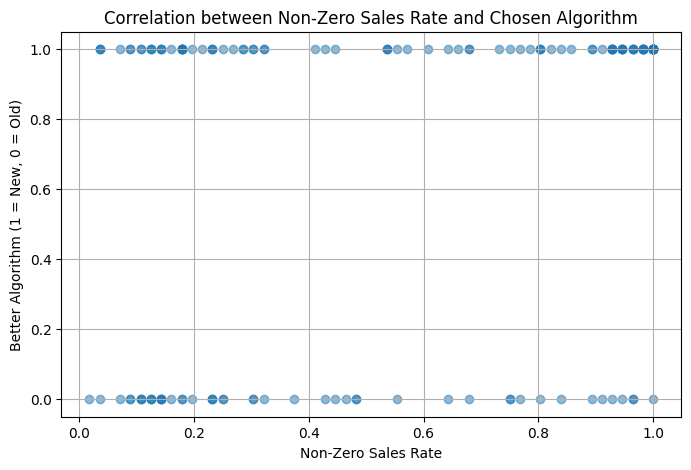

In [13]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load the filtered results
df = pd.read_excel("filtered_mae_comparison_results_with_non_zero_rate.xlsx")

# Convert "Better_Algorithm" into numerical values (1 = New, 0 = Old)
df["Better_Algorithm_Num"] = df["Better_Algorithm"].apply(lambda x: 1 if x == "New" else 0)

# Compute Pearson correlation
pearson_corr, pearson_pval = stats.pearsonr(df["Non_Zero_Sales_Rate"], df["Better_Algorithm_Num"])

# Compute Spearman correlation (for non-linear relationships)
spearman_corr, spearman_pval = stats.spearmanr(df["Non_Zero_Sales_Rate"], df["Better_Algorithm_Num"])

# Perform t-test: compare Non_Zero_Sales_Rate between groups
group_new = df[df["Better_Algorithm_Num"] == 1]["Non_Zero_Sales_Rate"]
group_old = df[df["Better_Algorithm_Num"] == 0]["Non_Zero_Sales_Rate"]
t_stat, t_pval = stats.ttest_ind(group_new, group_old, equal_var=False)

# Print results
print(f"Pearson Correlation: {pearson_corr:.4f}, P-value: {pearson_pval:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}, P-value: {spearman_pval:.4f}")
print(f"T-test: t-statistic = {t_stat:.4f}, P-value = {t_pval:.4f}")

# Plot scatter plot for visualization
plt.figure(figsize=(8, 5))
plt.scatter(df["Non_Zero_Sales_Rate"], df["Better_Algorithm_Num"], alpha=0.5)
plt.xlabel("Non-Zero Sales Rate")
plt.ylabel("Better Algorithm (1 = New, 0 = Old)")
plt.title("Correlation between Non-Zero Sales Rate and Chosen Algorithm")
plt.grid(True)
plt.show()
